In [ ]:
# Execute this cell to install dependencies
%pip install sf-hamilton[visualization]

# Static validator dev [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dagworks-inc/hamilton/blob/main/examples/validation/static_validator/notebook.ipynb) [![GitHub badge](https://img.shields.io/badge/github-view_source-2b3137?logo=github)](https://github.com/dagworks-inc/hamilton/blob/main/examples/validation/static_validator/notebook.ipynb)


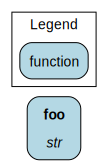

In [2]:
%%cell_to_module good_module --display
from hamilton.function_modifiers import tag

@tag(node_type="output", table_name="my_table")
def foo() -> str:
    return "Hello, world!"


In [ ]:
%load_ext hamilton.plugins.jupyter_magic

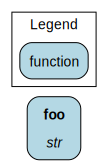

In [3]:
%%cell_to_module bad_module --display
from hamilton.function_modifiers import tag

@tag(node_type="output")
def foo() -> str:
    return "Hello, world!"

In [5]:
# Validator
from typing import Optional
from hamilton.lifecycle import api
from hamilton.graph_types import HamiltonNode


class MyTagValidator(api.StaticValidator):
    """Static validator that is run right after the graph is built."""

    def run_to_validate_node(
            self, *, node: HamiltonNode, **future_kwargs
    ) -> tuple[bool, Optional[str]]:
        if node.tags.get("node_type", "") == "output":
            table_name = node.tags.get("table_name")
            if not table_name:  # None or empty
                error_msg = f"Node {node.tags['module']}.{node.name} is an output node, but does not have a table_name tag."
                return False, error_msg
        return True, None

tag_validator = MyTagValidator()

In [6]:
from hamilton import driver

dr = (
    driver.Builder()
    .with_modules(good_module)
    .with_adapters(tag_validator)
    .build()
)
dr.execute([good_module.foo])

{'foo': 'Hello, world!'}

In [7]:
# this should error
dr = (
    driver.Builder()
    .with_modules(bad_module)
    .with_adapters(tag_validator)
    .build()
)

-------------------------------------------------------------------
Oh no an error! Need help with Hamilton?
Join our slack and ask for help! https://join.slack.com/t/hamilton-opensource/shared_invite/zt-2niepkra8-DGKGf_tTYhXuJWBTXtIs4g
-------------------------------------------------------------------



ValidationException: Node validation failed! 1 errors encountered:
  foo: Node bad_module.foo is an output node, but does not have a table_name tag.